### **Building a Transformer model with Encoder and Decoder layers**

#### **Encoderlayer**

The **EncoderLayer** consists of two sublayers: a **MultiHeadAttention** layer, more specifically **GlobalSelfAttention** layer, and a **FeedForward** layer. Each of these sublayers has a residual connection around it, followed by a layer normalization. Residual connections help to avoid the vanishing gradient problem in deep networks.

In [1]:
import numpy as np
import tensorflow as tf
from Positional_Encoding import PositionalEmbedding
from Transformer_Attentions import CrossAttention, GlobalSelfAttention, CausalSelfAttention, FeedForward

In [2]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Encoder. Usually there are multiple layers stacked on top of each other.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        self_attention (GlobalSelfAttention): The global self-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the EncoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
            )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

### **Encoder**

Now let's implement the **Encoder**. The Encoder has integrated the **PositionalEmbedding** layer, the multiple of **EncoderLayer** layers, and the **Dropout** layer. The output of each EncoderLayer is passed to the next EncoderLayer. The output of the last EncoderLayer will be the output of the Encoder. In the following image, you can see the Encoder marked in red:

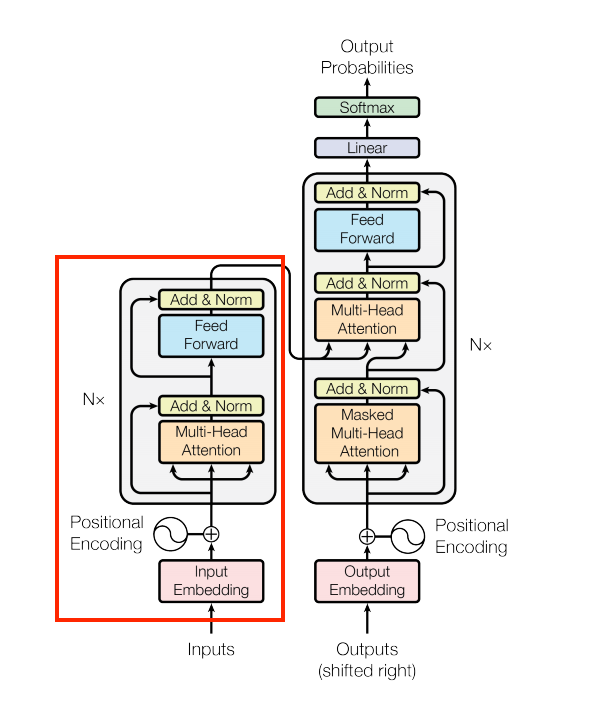

In [ ]:
class Encoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Encoder. This layer is mostly used in the Transformer models 
    for natural language processing tasks, such as machine translation, text summarization or text classification.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the encoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        enc_layers (list): The list of encoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Encoder.

        Args:
            num_layers (int): The number of layers in the encoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.
        
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length).

        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        x = self.pos_embedding(x)  
        # here x has shape `(batch_size, seq_len, d_model)`

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

#### **DecoderLayer layer**

The **DecoderLayer** is similar to the **EncoderLayer**, but it has an additional **CrossAttention** layer between the **CausalSelfAttention** layer and the **FeedForward** layer:

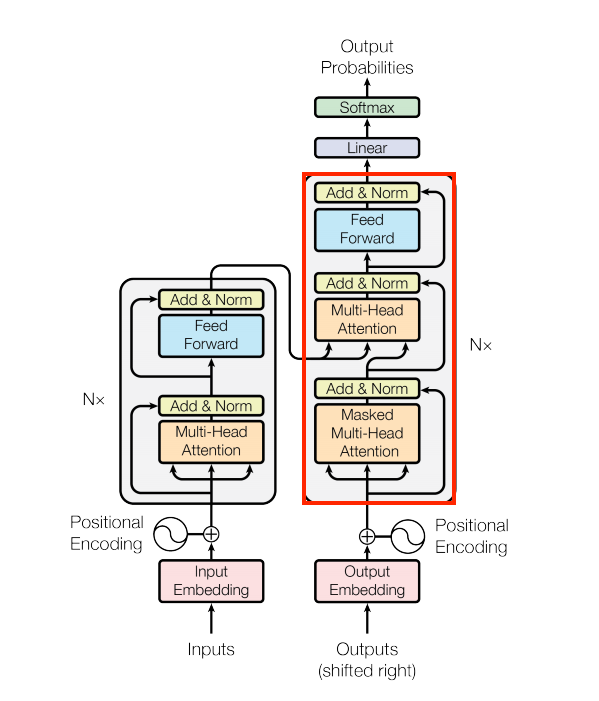

The **CrossAttention** layer calculates the attention weights between the decoder input and the encoder output. The **CausalSelfAttention** layer calculates the attention weights between the decoder input and the decoder output. The **FeedForward** layer transforms the representation of the input sequence into a more suitable form for the task at hand.

Let's implement the DecoderLayer layer:

In [3]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    A single layer of the Decoder. Usually there are multiple layers stacked on top of each other.
    
    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        causal_self_attention (CausalSelfAttention): The causal self-attention layer.
        cross_attention (CrossAttention): The cross-attention layer.
        ffn (FeedForward): The feed-forward layer.
    """
    def __init__(self, d_model: int, num_heads: int, dff: int, dropout_rate: float=0.1):
        """
        Constructor of the DecoderLayer.

        Args:
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            dropout_rate (float): The dropout rate. 
        """
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model). x is usually the output of the previous decoder layer.
            context (tf.Tensor): The context sequence of shape (batch_size, seq_length, d_model). Context is usually the output of the encoder.
        """
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

#### **Decoder**
Now let's implement the **Decoder**, which is very similar to the Encoder layer. The Decoder has integrated the **PositionalEmbedding** layer, the multiple of **DecoderLayer** layers, and the Dropout layer. The output of each DecoderLayer is passed to the next DecoderLayer. The output of the last DecoderLayer is the output of the Decoder. In the following image, you can see the Decoder marked in red:

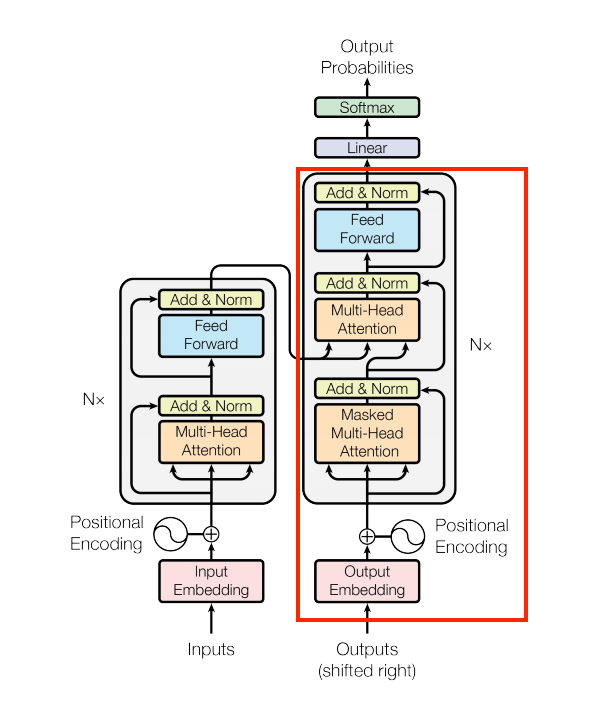


Let's implement the **Decoder** layer in the code:

In [4]:
class Decoder(tf.keras.layers.Layer):
    """
    A custom TensorFlow layer that implements the Decoder. This layer is mostly used in the Transformer models
    for natural language processing tasks, such as machine translation, text summarization or text classification.

    Methods:
        call: Performs the forward pass of the layer.

    Attributes:
        d_model (int): The dimensionality of the model.
        num_layers (int): The number of layers in the decoder.
        pos_embedding (PositionalEmbedding): The positional embedding layer.
        dec_layers (list): The list of decoder layers.
        dropout (tf.keras.layers.Dropout): The dropout layer.
    """
    def __init__(self, num_layers: int, d_model: int, num_heads: int, dff: int, vocab_size: int, dropout_rate: float=0.1):
        """
        Constructor of the Decoder.

        Args:
            num_layers (int): The number of layers in the decoder.
            d_model (int): The dimensionality of the model.
            num_heads (int): The number of heads in the multi-head attention layer.
            dff (int): The dimensionality of the feed-forward layer.
            vocab_size (int): The size of the vocabulary.
            dropout_rate (float): The dropout rate.
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(
                d_model=d_model, 
                num_heads=num_heads, 
                dff=dff, 
                dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the forward pass of the layer.

        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, target_seq_len).
            context (tf.Tensor): The context sequence of shape (batch_size, input_seq_len, d_model).
        """
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

You should see the following output:

decoder_input shape (1, 100)

decoder_output shape (1, 100, 512)

Now we tested it with random data. But imagine, if it were actual data, then we would have, for example, a Spanish sentence as input and an English sentence as output. Then we would have to translate Spanish sentences to English sentences. We would have to input a Spanish sentence to the encoder and an English sentence to the decoder. Then we would have to iterate over the decoder until we get the <**end**> token. Then we would have translated sentences.

As we can see, the output decoder shape is a (1, 100, 512) vector. On this layer, we would have to apply the argmax function to get the most probable token and pick the word from the dictionary to get the final word. But we will do it later.

#### **The Transformer**

Finally, we have implemented all the layers we need to build the **Transformer**. The Transformer consists of an **Encoder**, a **Decoder**, and a final linear layer. The output of the Decoder is the input to the final linear layer, and its result is returned as the output of the Transformer. The final Dense layer converts the resulting sequence into a probability distribution over the output vocabulary.

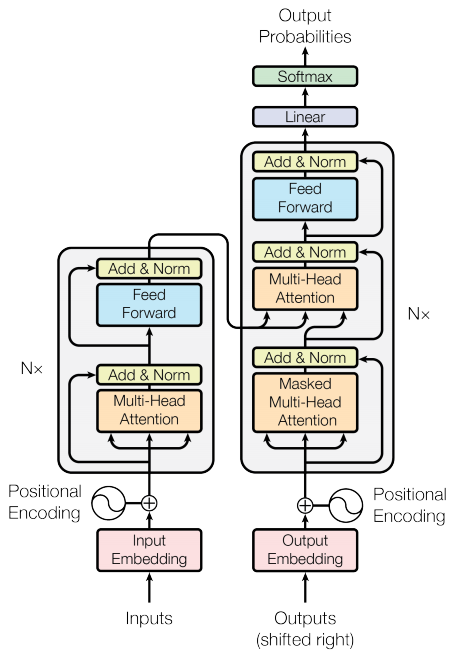


Now let's implement the Transformer model in TensorFlow:

In [5]:
def Transformer(
    input_vocab_size: int, 
    target_vocab_size: int, 
    encoder_input_size: int = None,
    decoder_input_size: int = None,
    num_layers: int=6, 
    d_model: int=512, 
    num_heads: int=8,
    dff: int=2048,
    dropout_rate: float=0.1,
    ) -> tf.keras.Model:
    """
    A custom TensorFlow model that implements the Transformer architecture.

    Args:
        input_vocab_size (int): The size of the input vocabulary.
        target_vocab_size (int): The size of the target vocabulary.
        encoder_input_size (int): The size of the encoder input sequence.
        decoder_input_size (int): The size of the decoder input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        d_model (int): The dimensionality of the model.
        num_heads (int): The number of heads in the multi-head attention layer.
        dff (int): The dimensionality of the feed-forward layer.
        dropout_rate (float): The dropout rate.

    Returns:
        A TensorFlow Keras model.
    """
    inputs = [
        tf.keras.layers.Input(shape=(encoder_input_size,), dtype=tf.int64), 
        tf.keras.layers.Input(shape=(decoder_input_size,), dtype=tf.int64)
        ]
    
    encoder_input, decoder_input = inputs

    encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)(encoder_input)
    decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)(decoder_input, encoder)

    output = tf.keras.layers.Dense(target_vocab_size)(decoder)

    return tf.keras.Model(inputs=inputs, outputs=output)

The **Encoder** is an instance of the **Encoder** class, responsible for taking a sequence of tokens as input and producing a sequence of contextual vectors, each representing information about a specific token in the input sequence.

The **Decoder** is also an instance of the **Decoder** class, which takes both a sequence of target tokens and the contextual information generated by the **Encoder** as input. It then generates a sequence of contextual vectors corresponding to each target token in the output sequence.

The **final_layer** is a Dense layer used to take the output from the **Decoder** and map it to a sequence of probabilities for the target tokens.

When we have a constructed **Transformer** Model, we provide an **input** tensor called **inputs**. This inputs tensor is actually a tuple containing two tensors: the **context** tensor (representing the input sequence for the **Encoder**) and the x tensor (representing the target sequence for the **Decoder**). When we call the Transformer model, it processes the **context** tensor through the **Encoder** to obtain contextual information for each token in the input sequence. It then uses this information and the x tensor to generate the output sequence through the **Decoder**. Finally, the model passes the output of the **Decoder** through the **final_layer** to obtain probabilities for the target tokens. The model returns both the logits (target token probabilities) and the attention weights.

The **Transformer** **Architecture** is Complete now we should use it however we want.build a **data** **pipiline** and train out model

The **End--->>**